In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np

np.float64(95.99553092424617)

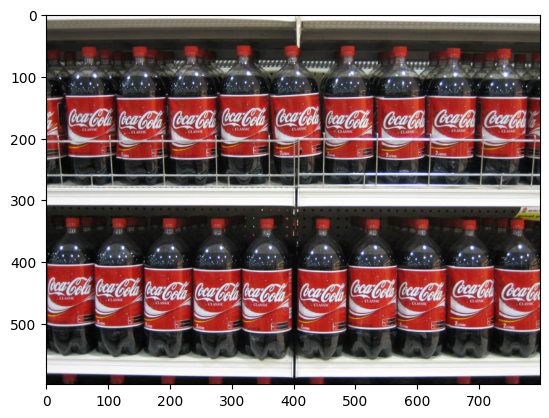

In [5]:
coca_multi = cv.cvtColor(cv.imread('images/coca_multi.png'), cv.COLOR_BGR2RGB)
plt.imshow(coca_multi)
np.mean(coca_multi)

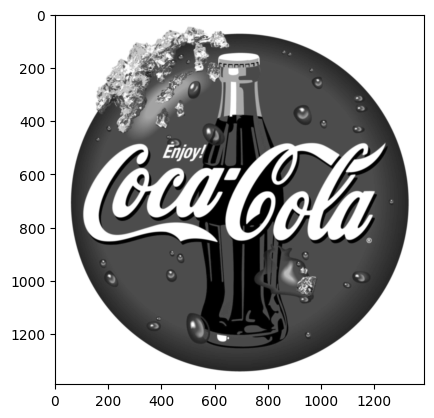

In [121]:
def filter_closed_loops(gray):
    _, binary = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(binary)
    for contour in contours:
        if not cv.isContourConvex(contour):
            if cv.arcLength(contour, cv.isContourConvex(contour)) > 100 and cv.contourArea(contour) > 20:
                cv.drawContours(mask, [contour], -1, 255, thickness=cv.FILLED)
    filtered_image = cv.bitwise_and(binary, mask)
    return filtered_image
    
def preprocess(image, kernel_size=5, threshold_1=100, threshold_2=200):
    grayscale = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if len(image.shape) == 3 else image.copy()
    blurred = cv.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
    canny_edges = cv.Canny(blurred, threshold_1, threshold_2)
    canny_edges_after_blur = cv.Canny(blurred,threshold_1, threshold_2)
    kernel = np.ones((3, 3), np.uint8) 
    filtered = filter_closed_loops(canny_edges_after_blur)
    return grayscale, blurred, canny_edges, canny_edges_after_blur, filtered

def preprocess_(image, kernel_size=5, threshold_1=100, threshold_2=200):
    return preprocess(image, kernel_size, threshold_1, threshold_2)[4]

grayscale, blurred, canny_edges, canny_edges_after_blur,filtered = preprocess(test_images_color[0], kernel_size=5)
plt.imshow(blurred, cmap='gray')

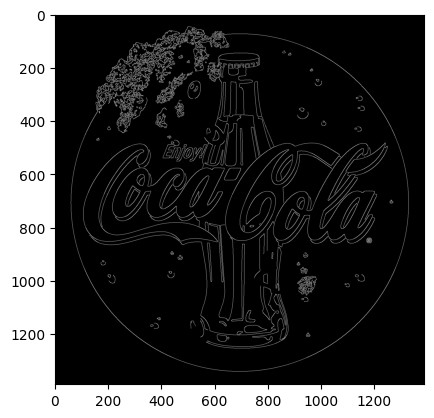

In [122]:
plt.imshow(canny_edges, cmap='gray')

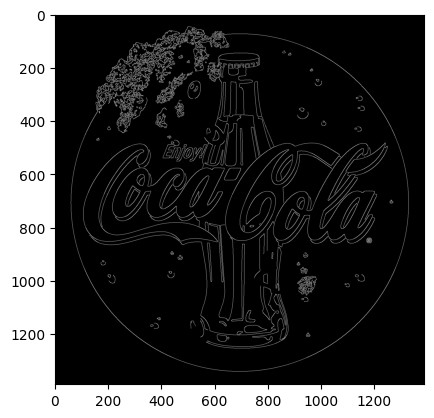

In [123]:
plt.imshow(canny_edges_after_blur, cmap='gray')

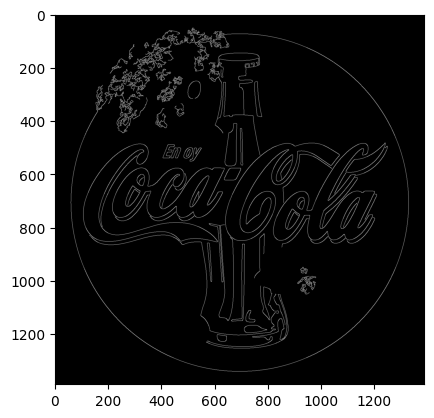

In [124]:
plt.imshow(filtered, cmap='gray')

2.9166666666666665

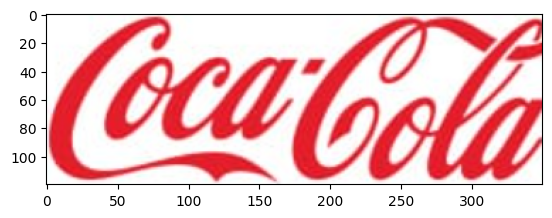

In [10]:
template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
template_reduced = template[30:-25, 10:-40]
plt.imshow(template_reduced)
aspect_ratio = template_reduced.shape[1]/template_reduced.shape[0]
aspect_ratio

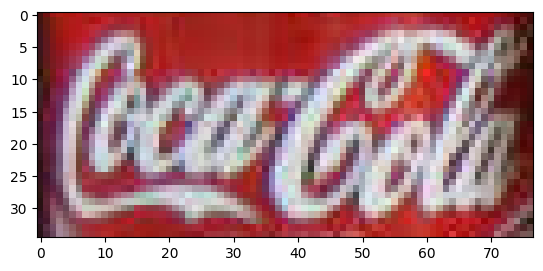

In [11]:
some_other = coca_multi.copy()
some_other = some_other[150:185,33:110,:]
plt.imshow(some_other)

In [12]:
some_other.shape

(35, 77, 3)

In [13]:
aspect_ratio = some_other.shape[1]/some_other.shape[0]
aspect_ratio

2.2

In [139]:
def get_templates():
    templates = []   
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    edged_template = preprocess_(template)
    for scale in np.linspace(0.2,10,20):
            resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
            for scale_w in np.linspace(0.5,1,5):
                h,w = resized.shape[:2]
                new_resized = cv.resize(resized, (int(w*scale_w),h))
                templates.append(new_resized)
    return templates
                

all_templates = get_templates()


0.37144557
-7.466753e-07


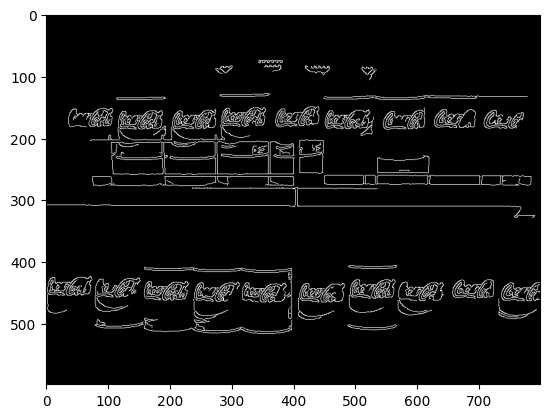

In [52]:
import imutils
import numpy as np
def normalize(x, xmax, xmin):
    return (x - xmin) / (xmax - xmin)

def detect_logo(image_rgb, method, threshold=0.80):
    template = cv.cvtColor(cv.imread('template/pattern.png'), cv.COLOR_BGR2RGB)
    # template_reduced = template[30:-25, 10:-15]
    # template_reduced = template[30:-25, 10:-40]
    edged_template = preprocess_(template)
    
    modified_image = image_rgb.copy()
    gray = cv.cvtColor(image_rgb, cv.COLOR_RGB2GRAY)
    tW, tH = gray.shape[::-1]
    found = {}    
    min_result = 1e20
    max_result = -1e20
    all_results = np.array([], dtype=np.float32)

    edged = preprocess_(image_rgb)
    plt.imshow(edged, cmap='gray')
    
    for scale in np.linspace(0.2,10,20):
        resized = imutils.resize(edged_template, width=int(edged_template.shape[1] * scale))
        for scale_w in np.linspace(0.5,1,5):
            h,w = resized.shape[:2]
            new_resized = cv.resize(resized, (int(w*scale_w),h))
            if new_resized.shape[0] <= 0.05 * image_rgb.shape[0] or new_resized.shape[1] <= 0.10*image_rgb.shape[1]:
                continue
            if new_resized.shape[0] > image_rgb.shape[0] or new_resized.shape[1] > image_rgb.shape[1]:
                continue
            try:
                result = cv.matchTemplate(edged, new_resized, method)
                found[f'{new_resized.shape[0]},{new_resized.shape[1]},{method}'] = result
                all_results = np.concatenate((all_results, result.flatten()))
                min_result = min(min_result, np.min(result))
                max_result = max(max_result, np.max(result))
            except Exception as e:
                pass

    print(max_result)
    print(min_result)
    bbox = []
    scores = []
    for scale_hash, result_scale in found.items():
        normalized_data = normalize(result_scale, max_result, min_result)
        loc = np.where(normalized_data >= threshold)
       
        h, w =[int(el) for el in scale_hash.split(',')[:2]]

        for pt in zip(*loc[::-1]):
            top_left = pt
            startX, startY = top_left[0], top_left[1]
            endX, endY = top_left[0]+w, top_left[1]+h
            cv.rectangle(modified_image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            bbox.append([startX, startY, endX, endY])
            scores.append(normalized_data[top_left[1], top_left[0]])

    return bbox, scores, normalize(all_results, max_result, min_result), modified_image

bbox_multi, scores_multi, hist_data, modified_image = detect_logo(coca_multi, cv.TM_CCORR_NORMED, threshold=0.80)


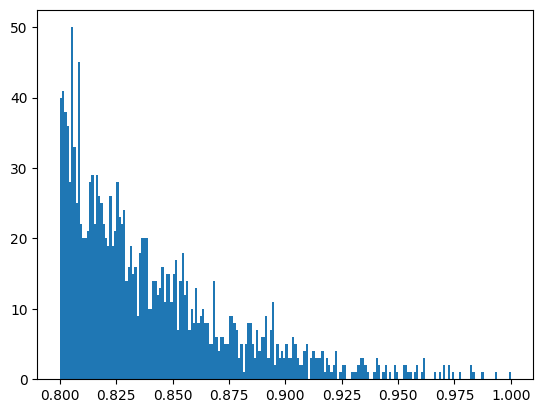

In [45]:
_ = plt.hist(hist_data, bins=200, range=(0.8,1))

In [ ]:
plt.imshow(modified_image)

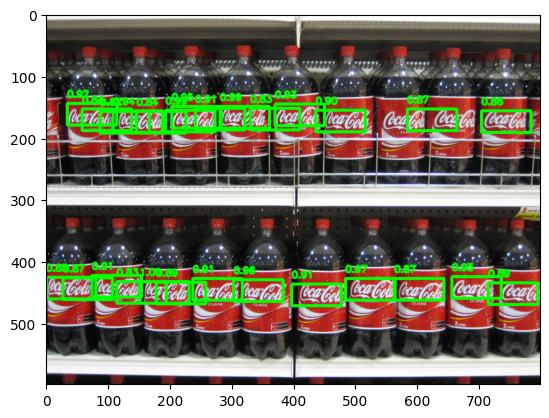

In [46]:
# Apply non-maximum suppression
coca_multi_copy = coca_multi.copy()
indices = cv.dnn.NMSBoxes(bboxes=bbox_multi, scores=scores_multi, score_threshold=0.82, nms_threshold=0.90, eta=0.99)
# Filter out the boxes based on the NMS result
filtered_boxes = [bbox_multi[i] for i in indices.flatten()]
filtered_scores = [scores_multi[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
    cv.rectangle(coca_multi_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    text = f"{score:.2f}"
    cv.putText(
        coca_multi_copy, 
        text, 
        (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
        cv.FONT_HERSHEY_SIMPLEX, 
        0.5,  # Font size
        (0, 255, 0),  # Font color (same as the box)
        2,  # Thickness
        cv.LINE_AA
    )
plt.imshow(coca_multi_copy)

0.15486097
-5.941469e-07


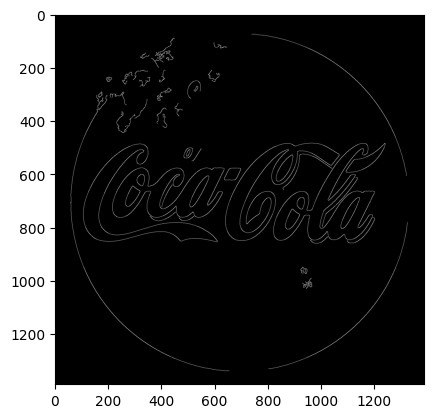

In [115]:
test_images = os.listdir('images')
test_images_paths = [f'images/{im}' for im in test_images]
test_images_color = [cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB) for path in [test_images_paths[0]]]


bbox_multi, scores_multi, hist_data, modified_image = detect_logo(test_images_color[0], cv.TM_CCORR_NORMED, threshold=0.70)

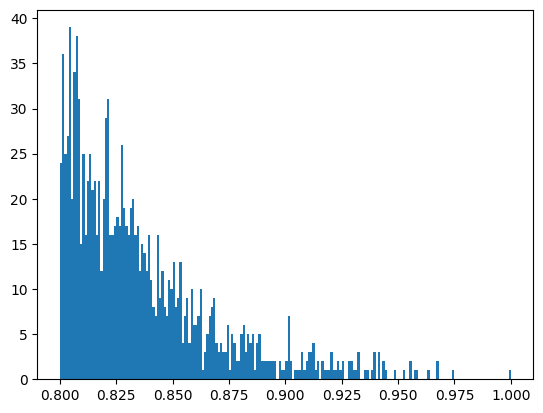

In [116]:
_ = plt.hist(hist_data, bins=200, range=(0.8,1))

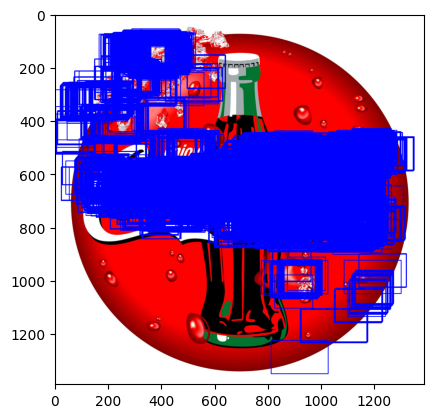

In [117]:
plt.imshow(modified_image)

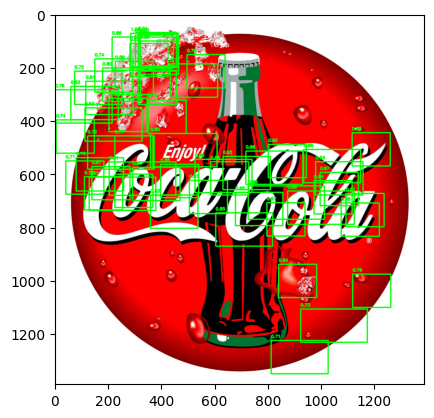

In [118]:
# Apply non-maximum suppression
coca_multi_copy = test_images_color[0].copy()
indices = cv.dnn.NMSBoxes(bboxes=bbox_multi, scores=scores_multi, score_threshold=0.5, nms_threshold=0.99, eta=0.99)
# Filter out the boxes based on the NMS result
filtered_boxes = [bbox_multi[i] for i in indices.flatten()]
filtered_scores = [scores_multi[i] for i in indices.flatten()]
# Draw the filtered boxes on the image
for (xmin, ymin, xmax, ymax), score in zip(filtered_boxes, filtered_scores):
    cv.rectangle(coca_multi_copy, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    text = f"{score:.2f}"
    cv.putText(
        coca_multi_copy, 
        text, 
        (xmin, ymin - 10),  # Position text slightly above the top-left corner of the box
        cv.FONT_HERSHEY_SIMPLEX, 
        0.5,  # Font size
        (0, 255, 0),  # Font color (same as the box)
        2,  # Thickness
        cv.LINE_AA
    )
plt.imshow(coca_multi_copy)

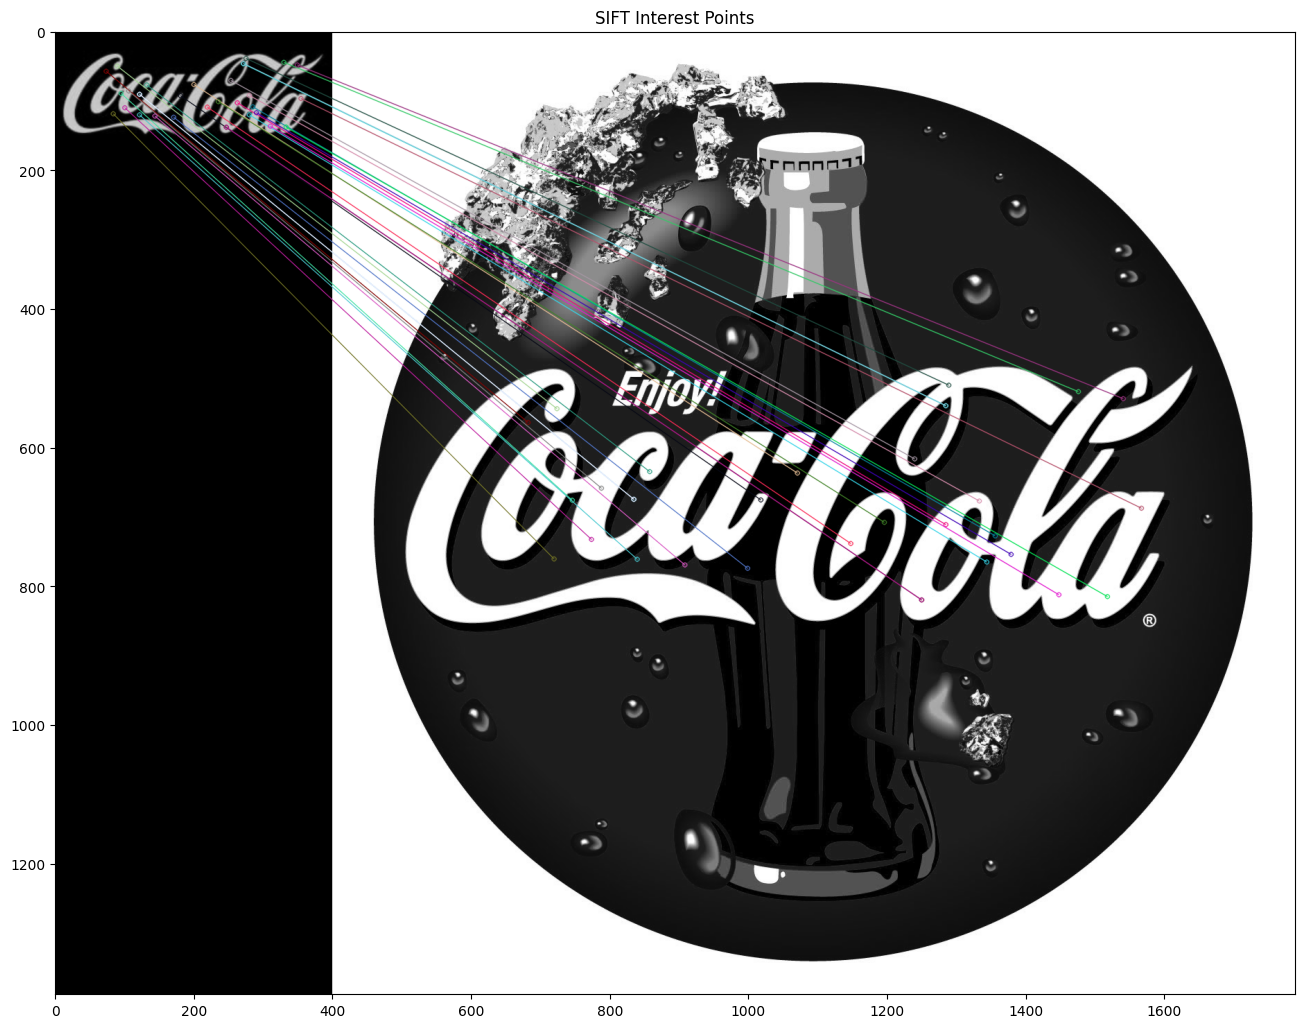

In [183]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
img1 = cv.bitwise_not(cv.cvtColor(template.copy(), cv.COLOR_BGR2GRAY))
img2 = cv.cvtColor(test_images_color[0].copy(),cv.COLOR_BGR2GRAY)
# template.copy()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
# good = matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 16))
plt.title('SIFT Interest Points')
plt.imshow(img3)
plt.show()

In [195]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
img1 = cv.bitwise_not(cv.cvtColor(template.copy(), cv.COLOR_BGR2GRAY))
img2 = cv.cvtColor(coca_multi.copy(),cv.COLOR_BGR2GRAY)
# template.copy()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# # BFMatcher with default params
# # bf = cv.BFMatcher()
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# # matches = bf.knnMatch(des1,des2,k=2)
# matches = bf.knnMatch(des1,des2,k=2)
# # Apply ratio test
# # good = matches
# # Sort them in the order of their distance.
# matches = sorted(matches, key = lambda x:x.distance)
# # good = []
# # for m,n in matches:
# #     if m.distance < 0.7*n.distance:
# #         good.append([m])
# # cv.drawMatchesKnn expects list of lists as matches.
# img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
# plt.figure(figsize=(16, 16))
# plt.title('SIFT Interest Points')
# plt.imshow(img3)
# plt.show()

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
 
# Match descriptors.
matches = bf.match(des1,des2)
 
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
 
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
plt.imshow(img3),plt.show()



error: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/core/src/batch_distance.cpp:282: error: (-215:Assertion failed) (type == CV_8U && dtype == CV_32S) || dtype == CV_32F in function 'batchDistance'
